# Chargement des modules

In [1]:
#!pip install tqdm

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# import pandas_datareader as web
import math
import yfinance as yf
import pandas as pd
import seaborn as sns
import seaborn.objects as so
from keras import Input
from keras import layers, Model
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
import random
import sys
sys.path.append('../..')
#import ep.etools as apt
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
from tqdm import tqdm
from pandas.tseries.offsets import DateOffset,BusinessDay

# Lecture des données brutes

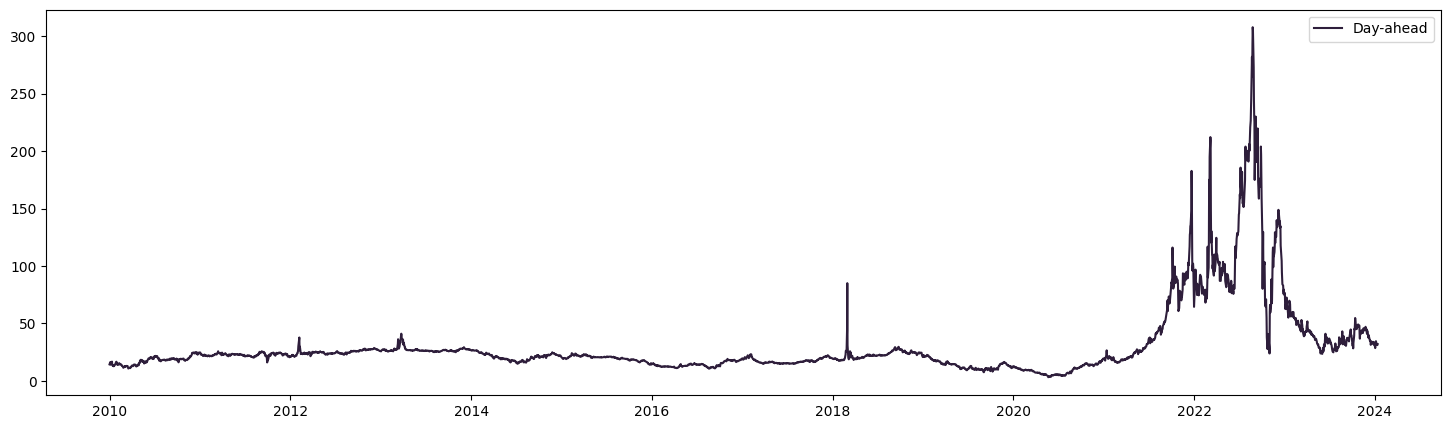

In [3]:
dataCalendar = pd.read_csv('./data/bloc_ttf_calendar_prices.csv')
dataPrices = pd.read_csv('./data/bloc_ttf_prices.csv')
dataPrices[' '] = pd.to_datetime(dataPrices[' '])
dataPrices = dataPrices.set_index(' ')
fig, ax = plt.subplots(figsize=(18,5))
sns.set_palette("mako")
sns.lineplot(dataPrices[['Day-ahead']][0:-1], color='Blue'); #3390
#ax2 = plt.twinx()
#sns.lineplot(data=final['€/$'], ax=ax2 , color='grey')

# Formatage des données
calcul des écarts entre jour J et J-1 en %
* Volatilité ! {{volatilite}}

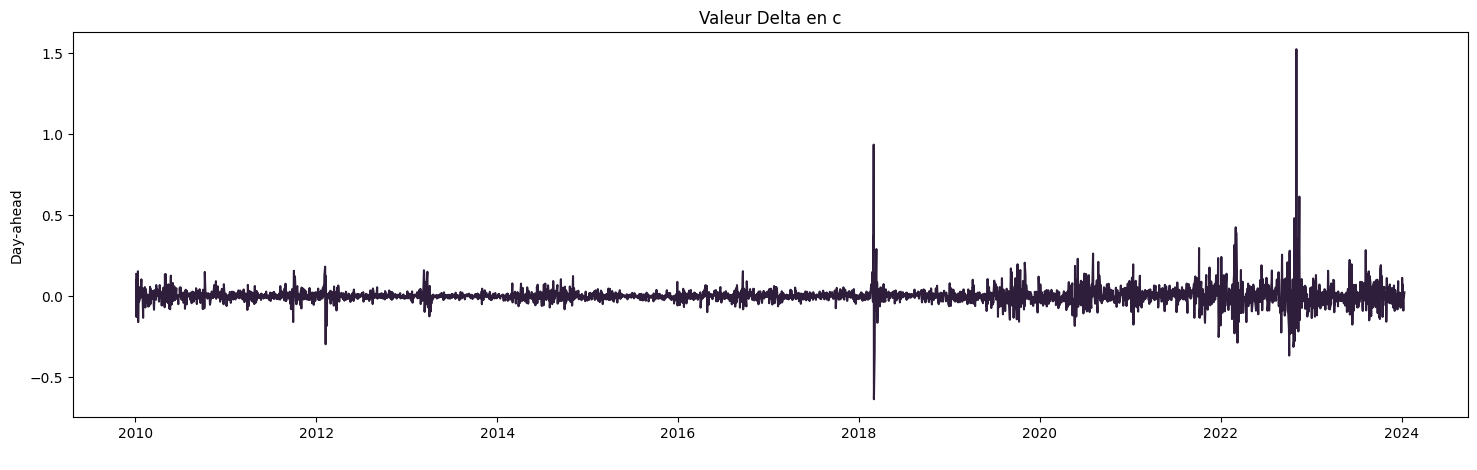

In [4]:
# période de calcul de la volatilité
volatilite = 0 # 260 = 1 an 0=> toutes les données historique
data=dataPrices['Day-ahead'].rolling(2).apply(lambda x: (x.iloc[1] - x.iloc[0])/x.iloc[0])[volatilite:-1]
fig, ax = plt.subplots(figsize=(18,5))
plt.title("Valeur Delta en c")
sns.lineplot(data);


# Comptage

Nombre d'échantillons  2160


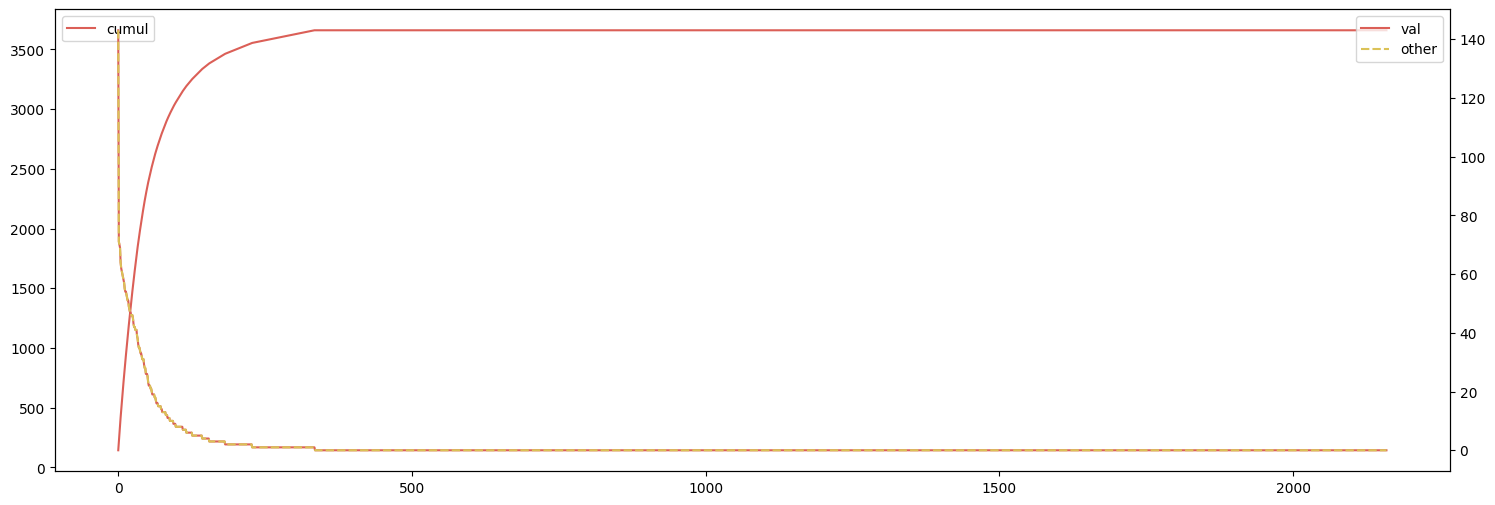

In [5]:
# create intervals
bins = np.arange(data.min(),data.max(),0.001)
histogramme = np.histogram(data,bins=bins)
histogramme = (np.insert(histogramme[0], histogramme[0].size, 1.0), histogramme[1])
# create a Series, indexed by interval midpoints
pdS = pd.Series(histogramme[0], index=histogramme[1]).to_frame()   #.to_dict()
print("Nombre d'échantillons ",pdS.size)
pdS = pdS.rename(columns={0:'val'})
pdS.sort_values('val',inplace=True,ascending=False)
pdS['other'] = pdS['val'].apply(lambda x: 0.000001 if (x<=0) else x)
pdS['freq'] = pdS.index.values
pdS['cumul'] = pdS['val'].cumsum(skipna=True)
# print(pdS.head(20))
pdS.reset_index(drop=True,inplace=True)
fig, ax = plt.subplots(figsize=(18,6))
# plt.yscale('log')
# plt.xscale('log')
sns.set_palette('hls',8)
sns.lineplot(pdS[['cumul']]);
ax2 = plt.twinx()
sns.lineplot(pdS[['val','other']], ax=ax2);

In [6]:
nbVal = pdS['val'].sum()
randomBase = np.zeros((nbVal,1))
cpt=0
for v in pdS.values:
    nb = int(v[0])
    for i in range(nb):
        randomBase[cpt] = v[2]
        cpt += 1
print(randomBase.size, randomBase[120])

3660 [-0.00011765]


# Interpolation en utilisant un réseau de Neurones

1.5228823529411786


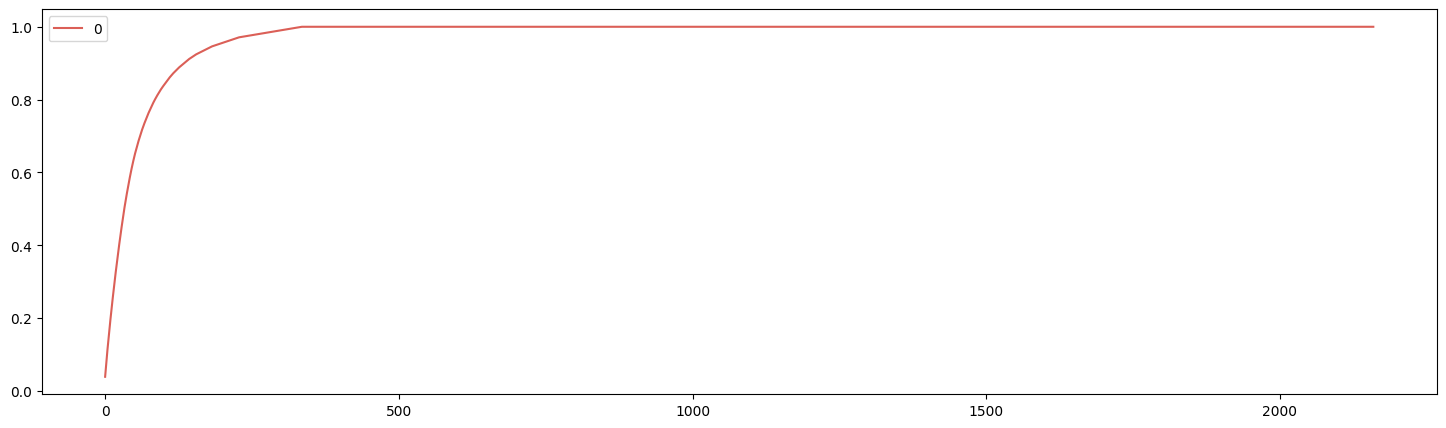

In [7]:
# initialisation des data
X = np.vstack(pdS['cumul'])
y = np.vstack(pdS['freq'])
features_len = 1
# normalisation des data
max = X.max()
X_norm = X / max
max = y.max()
print(max)
max =1.
y_norm = y / max;
fig = plt.figure(figsize=(18,5))
sns.lineplot(X_norm);

In [8]:
# le model Keras
input_data = Input(shape=(1,))
x = layers.Dense(32,activation='sigmoid')(input_data)
# x = layers.GRU(100, dropout=0.2,return_sequences=True, recurrent_dropout=0.5)(input_data)
# x = layers.LSTM(100, dropout=0.1, recurrent_dropout=0.5, return_sequences=True)(input_data)
# x = layers.GRU(32, dropout=0.2,recurrent_dropout=0.5, return_sequences=True)(x)
# x = layers.GRU(32, dropout=0.2,recurrent_dropout=0.5,activation='relu')(x)
# x = layers.Dropout(0.2)(x)
# x = layers.Dense(16,activation='relu')(x)
x = layers.Dense(8,activation='relu')(x)
output_data = layers.Dense(features_len)(x)
# with tf.device("/cpu:0"):
model = Model(input_data,output_data)

optimizer = Adam(learning_rate=0.01)
    # model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['mae','mse])
model.compile(optimizer=optimizer,loss='mean_squared_error',metrics=['mae'])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 32)                64        
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 337 (1.32 KB)
Trainable params: 337 (1.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/5


68/68 [==============================] - 1s 1ms/step - loss: 0.3995 - mae: 0.5438
Epoch 2/5
68/68 [==============================] - 0s 765us/step - loss: 0.3896 - mae: 0.5392
Epoch 3/5
68/68 [==============================] - 0s 700us/step - loss: 0.3969 - mae: 0.5428
Epoch 4/5
68/68 [==============================] - 0s 913us/step - loss: 0.3887 - mae: 0.5383
Epoch 5/5
68/68 [==============================] - 0s 894us/step - loss: 0.3896 - mae: 0.5386


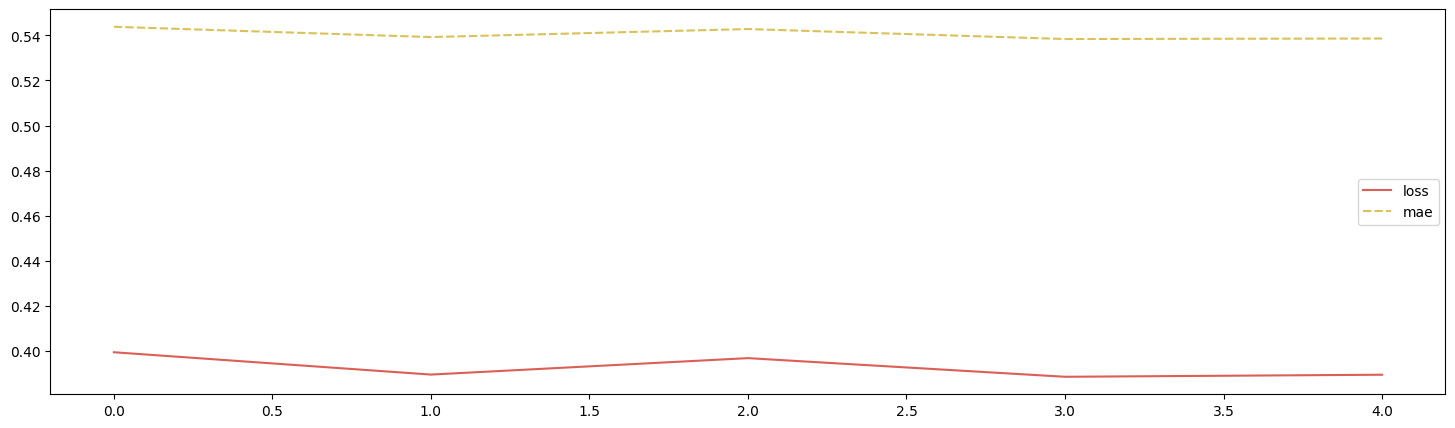

In [9]:
epochs = 5
run_dir = './run/'
save_dir = f'{run_dir}/best_model.h5'
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

history = model.fit(X_norm,y_norm,epochs=epochs,verbose=1,shuffle=True,batch_size=32, use_multiprocessing=True) #,callbacks = [bestmodel_callback])

fig = plt.figure(figsize=(18,5))
sns.lineplot(history.history);

# Générateur Aléatoire ...

In [10]:
def getRandomValue(df,crit,val,ref,max):
    # r = (np.random.uniform(0,max))
    r = np.random.randint(0,max)
    id = df[crit].loc[lambda x: x>=r].index.min()
    if (id>0):
        v = (df[val][id]-df[val][id-1])*(r-df[crit][id-1])/df[ref][id] + df[val][id-1]
    else:
        v = (df[val][id])*r/df[ref][id]
    return v

In [11]:
def getFastRandom(df,crit,val,ref,max):
    r = (np.random.uniform(0,max))
    id = df[crit].loc[lambda x: x>=r].index.min()
    return df[val][id]

In [12]:
def getOptimRandom(max):
    r = np.random.randint(0,max)
    return randomBase[r]

In [13]:
def getFromModel(nb,max):
    X = np.zeros((nb))
    for i in range(nb):
        r = (np.random.uniform(0,max))
        X[i]=r/max
    X = np.vstack(X)
    return model.predict(x=X)

313/313 [==============================] - 0s 645us/step


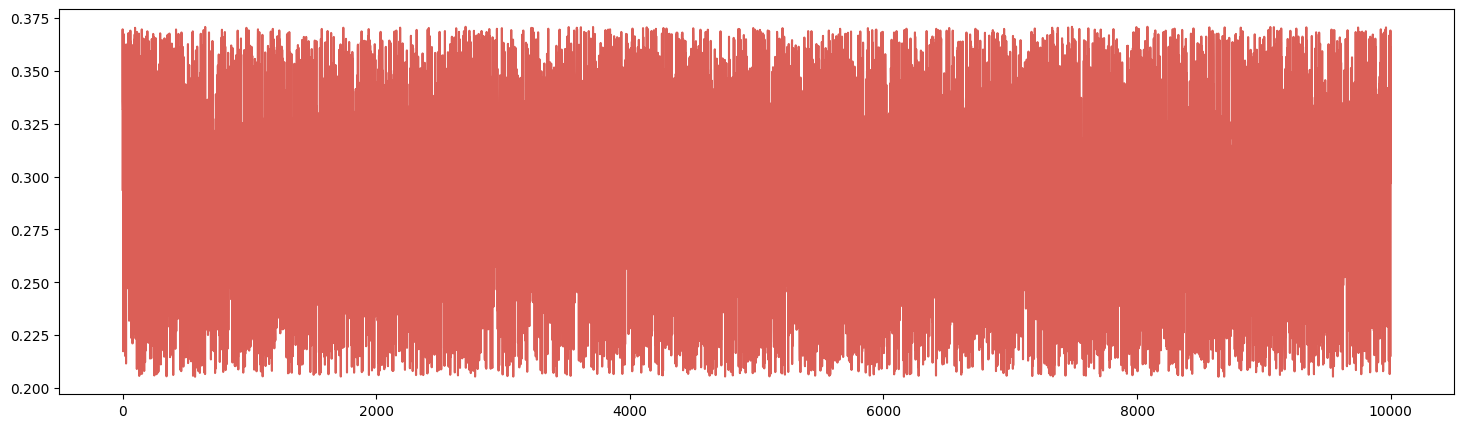

In [14]:
max = pdS['cumul'].max()
simul = getFromModel(10000,max)
# simul = model.predict(X_norm)
fig = plt.figure(figsize=(18,5))
plt.plot(simul);

3660
test unitaire du générateur:  [0.07688235]
Test sur 100000 échantillons, soit un équivalent de 385 années


100%|██████████| 100000/100000 [00:00<00:00, 432357.46it/s]


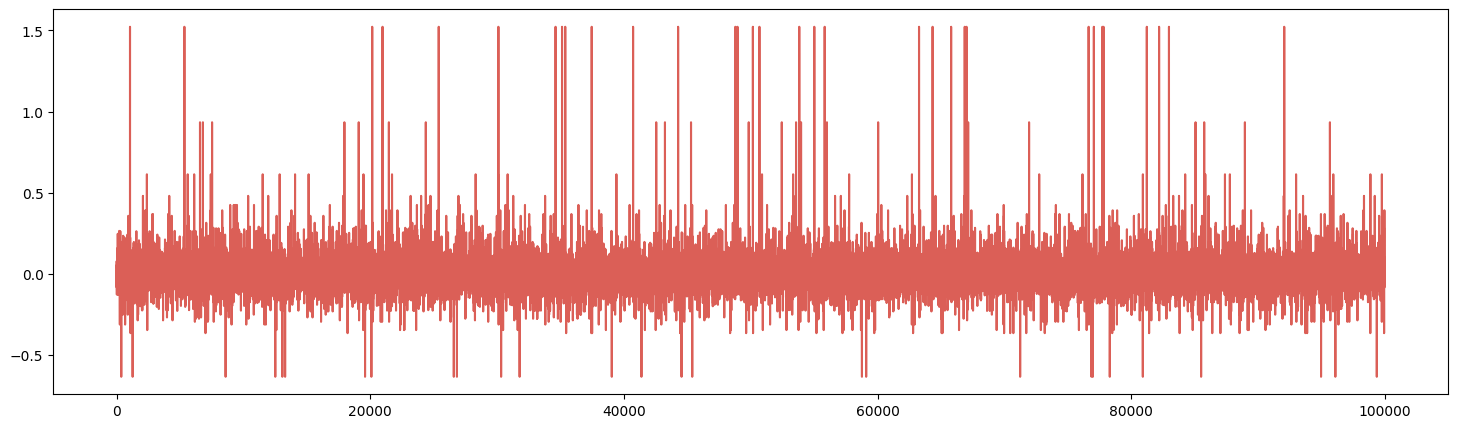

In [15]:
max = pdS['cumul'].max()
print(max)
print('test unitaire du générateur: ',getOptimRandom(max))
# print('test unitaire du générateur: ',getRandomValue(pdS,'cumul','freq','val',max))

nbEchantillon = 100000
print("Test sur",nbEchantillon,'échantillons, soit un équivalent de',round(nbEchantillon/260),'années')
simul = np.ones(nbEchantillon)
for i in tqdm(range(nbEchantillon)):
    simul[i] = (getOptimRandom(max)[0])
    # simul[i] = (getFastRandom(pdS,'cumul','freq','other',max))
    
fig = plt.figure(figsize=(18,5))
plt.plot(simul);

# On passe à la simulation sur 6 mois ...

In [16]:
# initialisation des valeurs de départ
nbEchantillon = 260
max = pdS['cumul'].max()
len = dataPrices['Day-ahead'].size
if (volatilite>0):
    len = volatilite
ancData = np.zeros((101,len))
ancData[0] = dataPrices['Day-ahead'][-volatilite:]
# print('ici',ancData[0].size)
startVal = ancData[0][-1]
startDate = dataPrices['Day-ahead'].index[-1]
forecast=np.zeros((10000,nbEchantillon))
forecastDate = np.empty([nbEchantillon],dtype='object')
for i in tqdm(range(10000)):
    val = startVal
    date = startDate
    # simul = pd.Series([startVal],index=[startDate]);
    simul = np.zeros((nbEchantillon))
    for j in range(nbEchantillon):
        val = (1 + getOptimRandom(max)) * val;
        # val = (1 + getFastRandom(pdS,'cumul','freq','other',max)) * val;
        if (i==0):
            date = date + BusinessDay(1)
            forecastDate[j] = date
        # print(val)
        simul[j] = val[0]
    # print(simul.values)
    forecast[i] = (simul)
print(forecast.shape)
# fig = plt.figure(figsize=(18,8))
# palette = sns.color_palette("Paired")
# sns.set_palette(palette=palette)
# plt.plot(forecast.T[0:3]);

100%|██████████| 10000/10000 [00:09<00:00, 1088.55it/s]

(10000, 260)


40.94436350446566 108.96420986136131 15.024102737146041


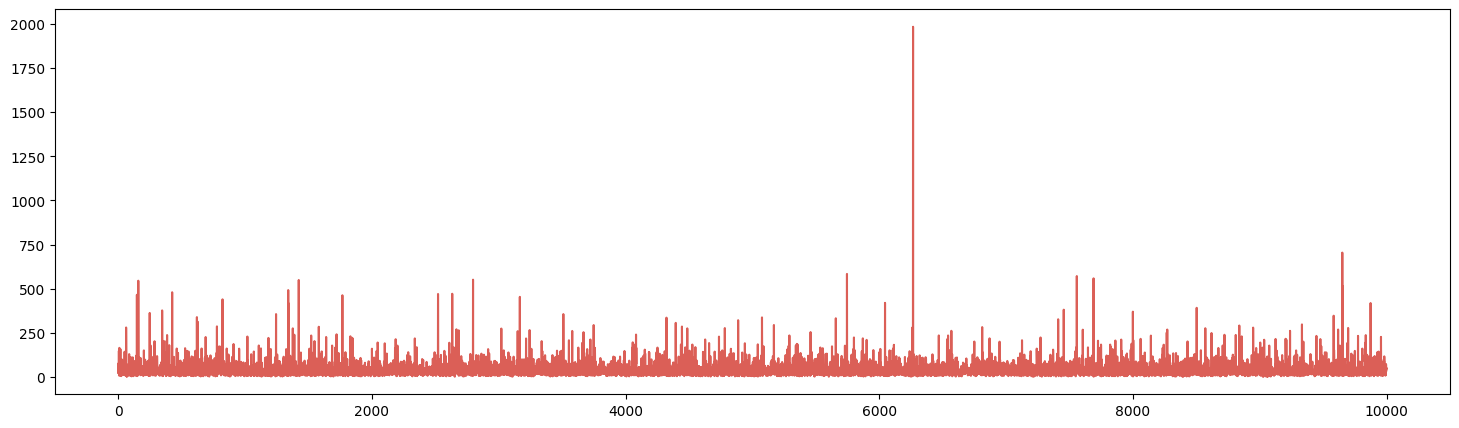

In [17]:
# end = ancData.index[-1]
# val = ancData.loc[startDate+BusinessDay(10)].values
# val = ancData.loc[end].values
val = forecast.T[nbEchantillon-60]
val = val[1:]
fig = plt.figure(figsize=(18,5))
plt.plot(val);
print(val.mean(), np.percentile(val,95),np.percentile(val,20))

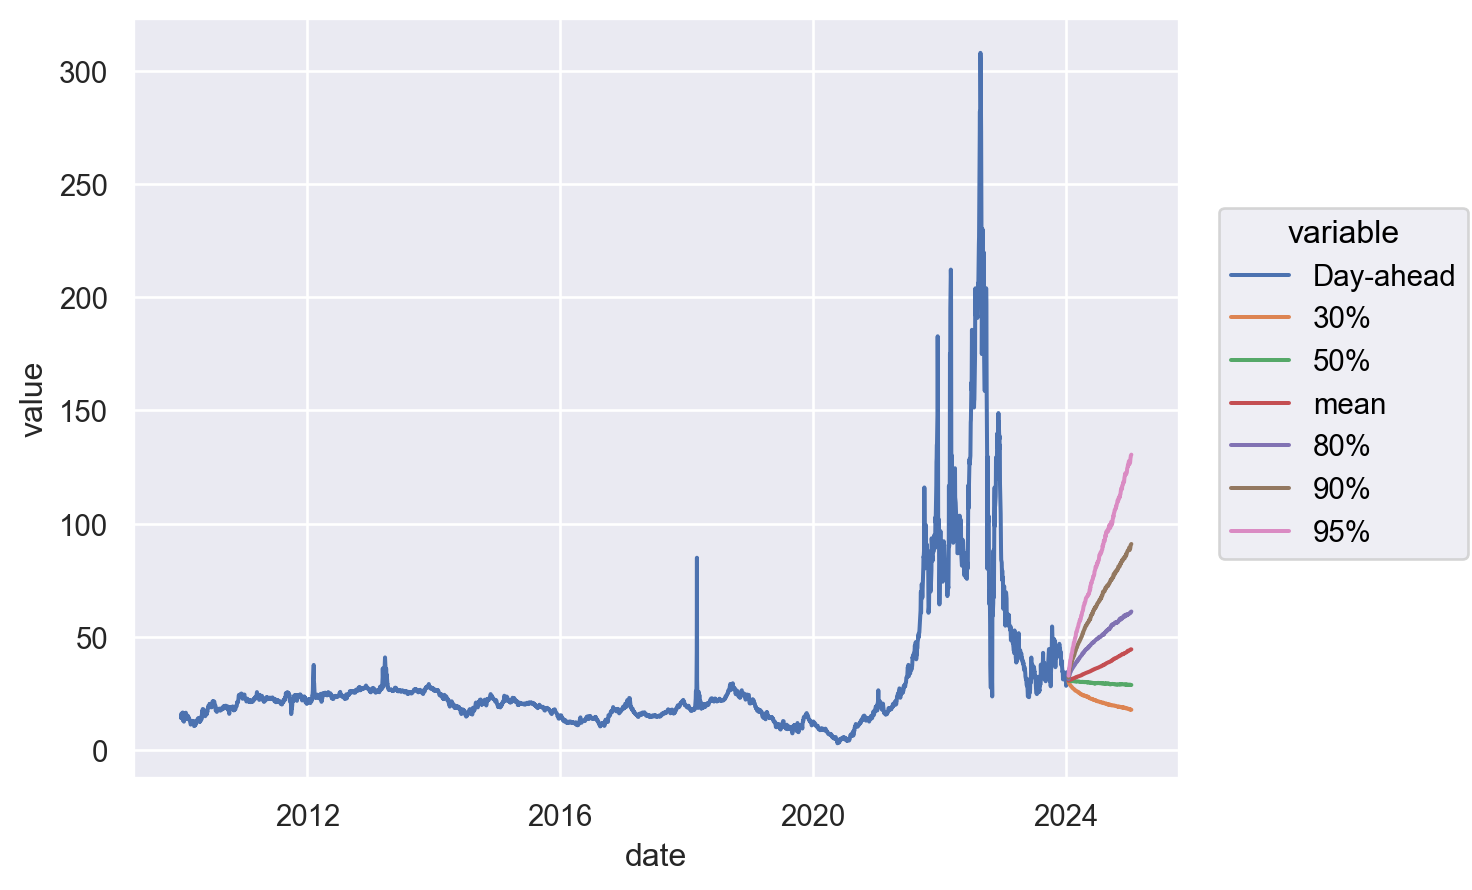

<Figure size 1800x500 with 0 Axes>

In [18]:
# print(startDate,end)
# print(np.busday_offset(['2024-01-12','2024-07-17'],0))
# print(np.busday_count(np.datetime64(startDate,'D'),np.datetime64(end,'D')))
# count = np.timedelta64(end-startDate,'D').astype(int)
# count = np.busday_count(np.datetime64(startDate,'D'),np.datetime64(end,'D')).astype(int)
# print(count)
# simulUnique = ancData.
canal  = np.empty((6,nbEchantillon))
for i in range(nbEchantillon):
    # val = ancData.loc[startDate+BusinessDay(i)].values
    val = forecast.T[i]
    val = val[1:]
    j=0
    canal[j][i] = np.percentile(val,30)
    j+=1
    canal[j][i] = np.percentile(val,50)
    j+=1
    canal[j][i] = val.mean()
    j+=1
    canal[j][i] = np.percentile(val,80)
    j+=1
    canal[j][i] = np.percentile(val,90)
    j+=1
    canal[j][i] = np.percentile(val,95)
    # print(i,startDate+BusinessDay(i),val.mean())
# mise en forme Pandas
dataForm = pd.DataFrame(data=canal.T,columns=['30%','50%','mean','80%','90%','95%'], index=forecastDate)
dataForm.index.name ='date'
historique = pd.DataFrame(dataPrices['Day-ahead'][-volatilite:])
historique.index.name ='date'
Allvalues = pd.melt(pd.concat([historique,dataForm]),value_vars=['Day-ahead','30%','50%','mean','80%','90%','95%'],ignore_index=False)
# Affichage du graphique
fig = plt.figure(figsize=(18,5))
palette = sns.color_palette("crest")
(
so.Plot(Allvalues,x='date',y='value',color='variable')
.add(so.Line(),so.Agg())
# .scale(
#         x=so.Continuous().tick(every=20)#.label(mdates.DateFormatter('%y-%m'))
#         # y=so.Continuous().label(like="${x:.0f}"),
#         # color=so.Continuous().tick(at=[1, 2, 3, 4]),
#     )
)

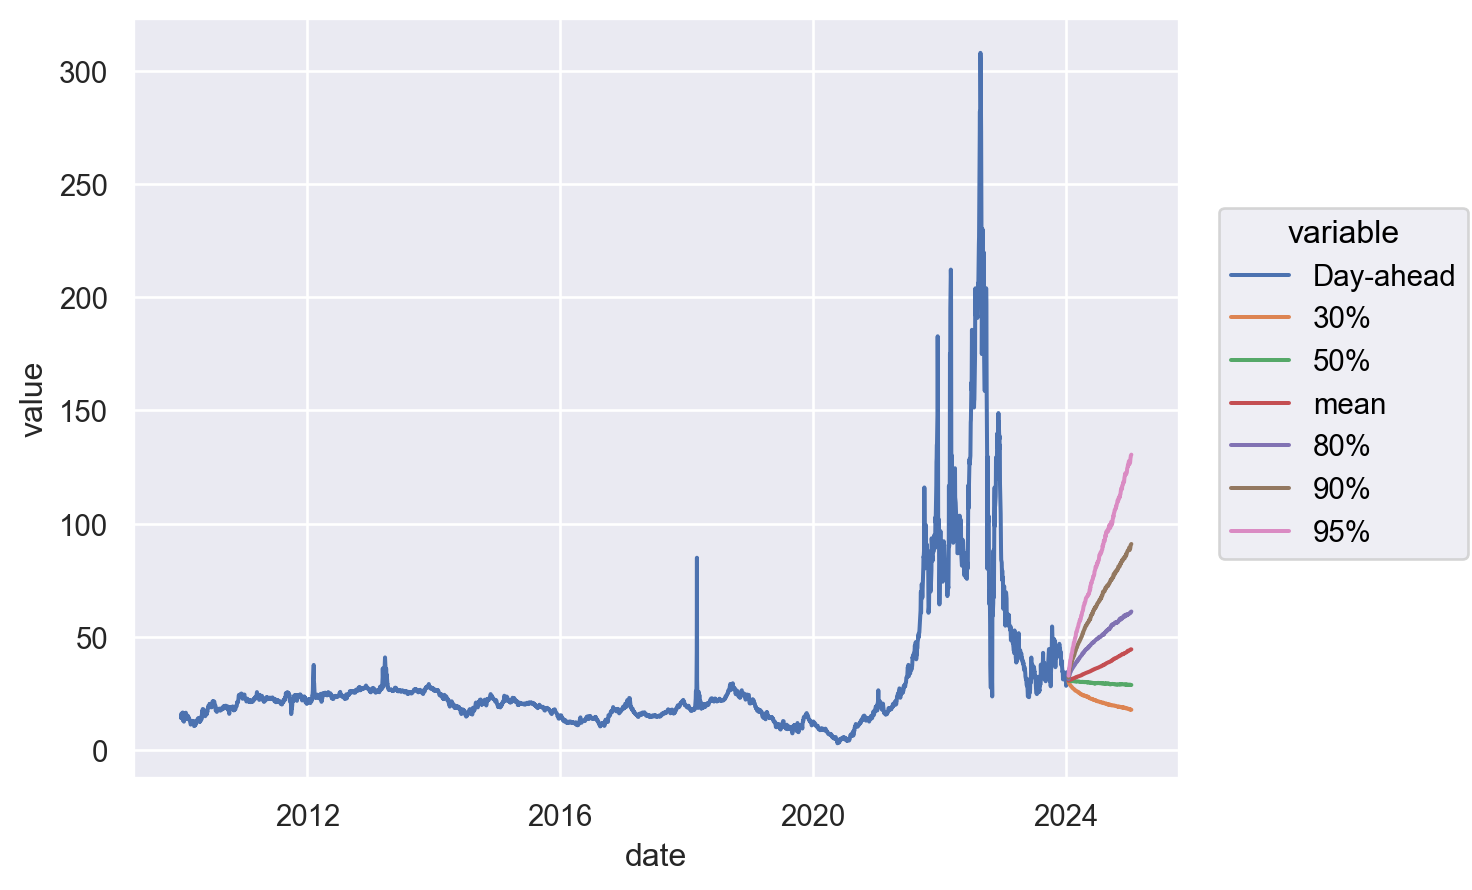

In [19]:
# palette = sns.color_palette("crest")
(
so.Plot(Allvalues,x='date',y='value',color='variable')
.add(so.Line(),so.Agg())
# .scale(
#         x=so.Continuous().tick(every=20)#.label(mdates.DateFormatter('%y-%m'))
#         # y=so.Continuous().label(like="${x:.0f}"),
#         # color=so.Continuous().tick(at=[1, 2, 3, 4]),
#     )
)
